# **Compute Range-Doppler**

In this notebook, we will learn how to Compute Range and Doppler veolicties using real Radar data from the Radical dataset. We will perform these computations from scratch so we can really understand what's going on. Before cmpleting this tutorial, it's recommended to take a look at this [FMCW Radar overview](https://www.ti.com/content/dam/videos/external-videos/2/3816841626001/5415528961001.mp4/subassets/mmwaveSensing-FMCW-offlineviewing_0.pdf). This will provide the basic background.

<br>

Here are some optional resources to better understand the TI mmwave Radar hardware:
- https://www.ti.com/lit/an/swra553a/swra553a.pdf?ts=1714172430750
- https://www.ti.com/lit/an/spracf4c/spracf4c.pdf?ts=1714138548659

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Data can be downloaded from the following sources:

- data: https://fireball.teckyianlim.me/file/flaming-cake/indoor_sample_50.h5 (md5sum: b195ff422cc4c979eeb81623899050cb)
- config: https://raw.githubusercontent.com/moodoki/radical_sdk/master/samples/indoor_human_rcs.cfg

You can download these files and replace their respective paths below

In [2]:
DATA_PATH = "../indoor_sample_50.h5"
CONFIG_PATH = "/home/iberrios/Documents/datasets/radical/data/radarcfg/indoor_human_rcs.cfg"

Access data without radical sdk

In [3]:
import h5py

data_dict = {}
with h5py.File(DATA_PATH, 'r') as h5_obj:

    for key in h5_obj.keys():
        print(key, 'shape: ', h5_obj[key].shape)
        data_dict.update({key : np.asarray(h5_obj[key])})

depth shape:  (50, 720, 1280)
depth_timestamp shape:  (50, 1)
radar shape:  (50, 32, 8, 304)
radar_timestamp shape:  (50, 1)
rgb shape:  (50, 720, 1280, 3)
rgb_timestamp shape:  (50, 1)


In [4]:
data_dict['radar'].shape

(50, 32, 8, 304)

In [5]:
data_idx = 28
adc_data = data_dict['radar'][data_idx, ...]

In [6]:
adc_data.shape

(32, 8, 304)

## Process Range

In [7]:
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)
range_cube.shape

(304, 8, 32)

In [8]:
# range at each chirp (summed across antennas)
range_bin_chirps = range_cube.sum(axis=1)

# range at each antenna (summed across all chirps)
range_bin_ants = range_cube.sum(axis=2)

In [9]:
range_bin_chirps.shape

(304, 32)

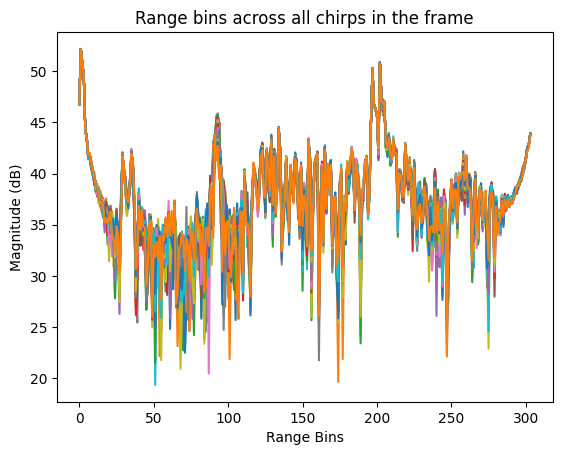

In [10]:
plt.plot(10*np.log10(np.abs( range_bin_chirps)))
# plt.plot(np.abs(range_cube.sum(axis=1)))
plt.title("Range bins across all chirps in the frame")
plt.xlabel("Range Bins")
plt.ylabel("Magnitude (dB)");

In [11]:
rgb_image = data_dict['rgb'][data_idx, ...]

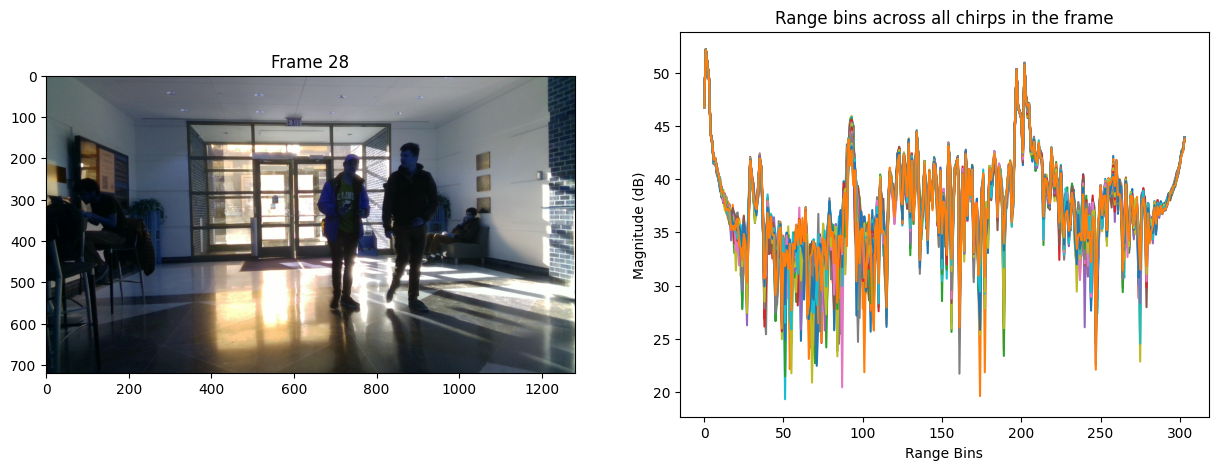

In [12]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(rgb_image)
ax[0].set_title("Frame 28")
ax[1].plot(10*np.log10(np.abs( range_bin_chirps)))
ax[1].set_title("Range bins across all chirps in the frame")
ax[1].set_xlabel("Range Bins")
ax[1].set_ylabel("Magnitude (dB)");

## Process Doppler

To process the Doppler information from the ADC data, we are going to take another FFT across the chirps, this is known as the slow time FFT because it takes longer to aquire the returns from all the chirps as opposed to sampling range bins which occurs on every chirp.

In [13]:
range_cube.shape

(304, 8, 32)

Our Radar data was collected using Time Division Multiplexing, meaning that each transmit antenna sent chirps alternating in time, one after the other. This allows the receive antennas to easily determine which transmit antenna sent the chirp. The time that it takes for all transmit antennas to send a chirp is known as a block. The downside of this is that the reduced number of chirps per tx antenna leads to a reduced max unambiguous velocity.

In [14]:
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

Compute Power Spectrum and sum the log of each virtual antenna component to get a good notion of SNR

In [15]:
range_doppler_psd = 10*np.log10( np.abs(range_doppler)**2 ).sum(axis=1).T

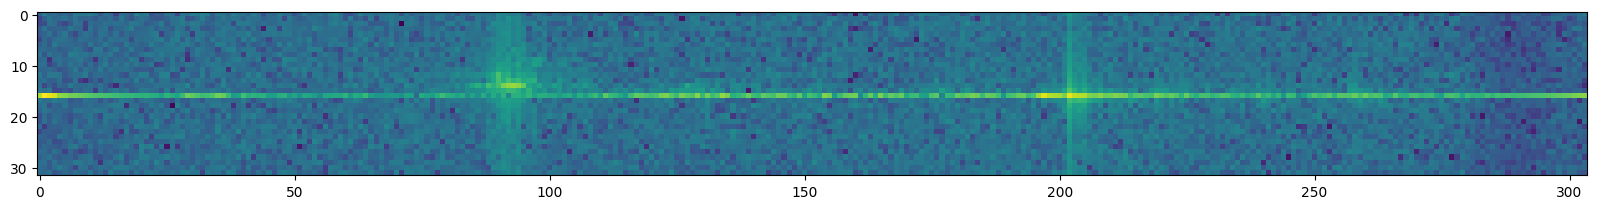

In [16]:
plt.figure(figsize=(20, 5))
plt.imshow(np.log(np.abs(range_doppler.sum(axis=1)).T));

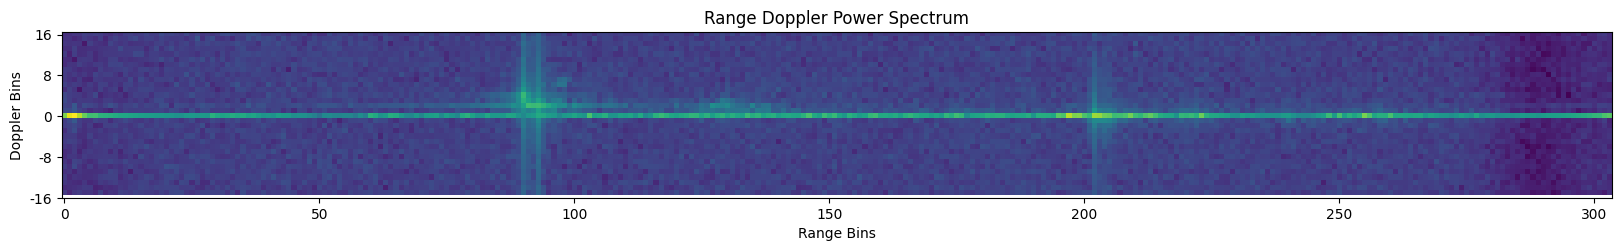

In [33]:
_, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.imshow(range_doppler_psd)
ax.set_title("Range Doppler Power Spectrum")
ax.set_xlabel("Range Bins")
ax.set_ylabel("Doppler Bins");

# set Doppler Bin Ticks
ax.set_yticks([0, 8, 16, 24, 32], [16, 8, 0, -8, -16]);

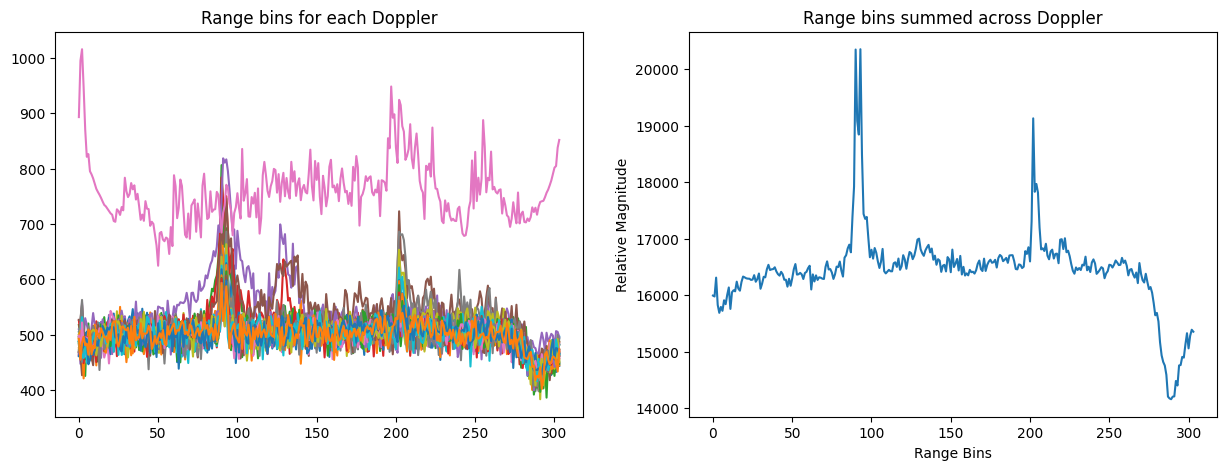

In [18]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range_doppler_psd.T); # plot range hits from each Doppler Bin
ax[0].set_title("Range bins for each Doppler")
ax[1].set_xlabel("Range Bins")
ax[1].set_ylabel("Relative Magnitude");
ax[1].plot(range_doppler_psd.sum(axis=0)); # Sum Range hits across Doppler Bins
ax[1].set_title("Range bins summed across Doppler")
ax[1].set_xlabel("Range Bins")
ax[1].set_ylabel("Relative Magnitude");

In [19]:
range_doppler_psd.shape

(32, 304)

Let's take another look

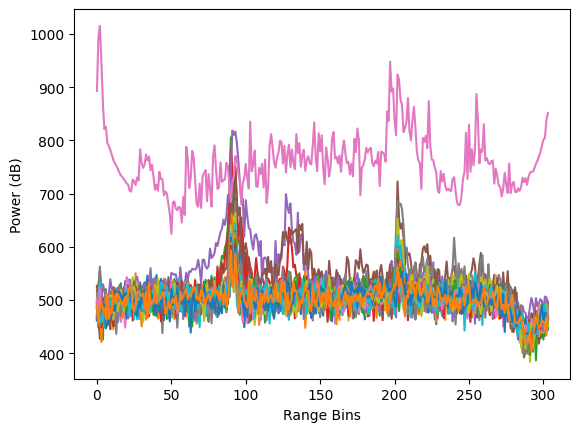

In [20]:
plt.plot(range_doppler_psd.T);
plt.xlabel("Range Bins");
plt.ylabel("Power (dB)");

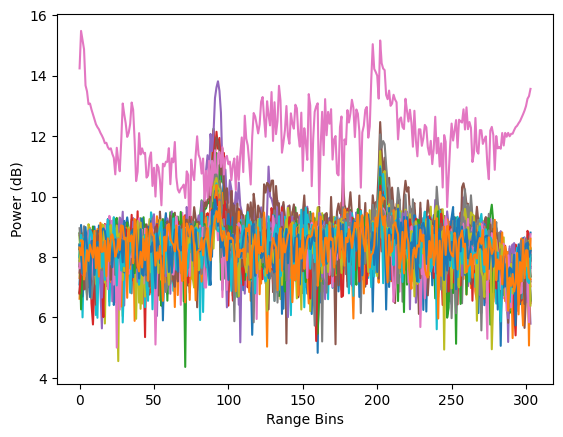

In [21]:
plt.plot(np.log(np.abs(range_doppler.sum(axis=1))));
plt.xlabel("Range Bins");
plt.ylabel("Power (dB)");

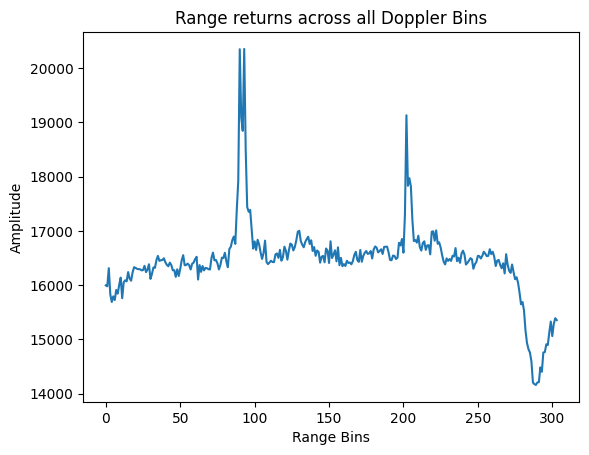

In [22]:
plt.plot(range_doppler_psd.T.sum(axis=1));
plt.title("Range returns across all Doppler Bins")
plt.xlabel("Range Bins");
plt.ylabel("Amplitude");

Get info from Radar Config file

Even though it's easier to use Radical SDK, we are going to extract these from scratch so we can get an understanding. See the [radical sdk code](https://github.com/moodoki/radical_sdk/blob/master/radicalsdk/radar/config_v1.py) for info on different parameters and see [this](https://www.ti.com/lit/an/swra553a/swra553a.pdf?ts=1714172430750) for info on the units 

<br>

*NOTE:* normally we will just use the script from Radical SDK to easily parse the Radar  config into a dict

## Add Real units

Now let's add the actual Range and Doppler Values, to do this we will need to go to our config file

In [23]:
with open(CONFIG_PATH, 'r') as f:
    for line in f.readlines():
        if 'profileCfg' in line:
            line = line.split(' ')

            start_freq = float(line[2]) # GHz
            idle_time = float(line[3]) # usec
            ramp_end_time = float(line[5]) # usec
            chirp_slope = float(line[8]) # MHz/usec
            num_adc_samples = float(line[10]) # unitless
            adc_sample_rate = float(line[11]) # Msps

        elif 'channelCfg' in line:
            line = line.split(' ')

            # number of receive antennas
            rx_bin = bin(int(line[1])).zfill(4)
            num_rx = len([i for i in rx_bin if i == '1'])

            # number of transmit antennas
            tx_bin = bin(int(line[2])).zfill(4)
            num_tx = len([i for i in tx_bin if i == '1'])


print(f"Number of Rx Antennas: {num_rx}")
print(f"Number of Tx Antennas: {num_tx}")
print(f"Start Frequency: {start_freq} GHz")
print(f"Idle Time: {idle_time} usec")
print(f"Ramp End Time: {ramp_end_time} usec")
print(f"Chirp Slope: {chirp_slope} MHz/usec")
print(f"Number of ADC Samples: {num_adc_samples}")
print(f"ADC sample rate: {adc_sample_rate} Msps")

Number of Rx Antennas: 4
Number of Tx Antennas: 2
Start Frequency: 77.0 GHz
Idle Time: 58.0 usec
Ramp End Time: 40.0 usec
Chirp Slope: 100.0 MHz/usec
Number of ADC Samples: 304.0
ADC sample rate: 9499.0 Msps


Idle Time is the dead/idle time between the end of the previous chirp to the next chirp

Ramp End Time is the time from the start of the Ramp until the end of the ramp

The entire interval for a single chirp is the sum of these two values

Now let's compute the Range resolution from scratch using the frame parameters

$$

\begin{align*}

    \text{Chirp Slope: } \qquad & S \; \left( \frac{MHz}{\mu sec} \right)
    \\
    \\
    \text{Sampling Period: } \qquad & T \; \left( sec \right)
    \\
    \\
    \text{Sampling Rate: } \qquad & F_s \; \left( \frac{1}{T_c} \right)
    \\
    \\
    \text{Bandwidth: } \qquad & B = S * T_c 
    \\
    \\
    \text{Range Resolution: } \qquad & d_{res} = \frac{c}{2 B}
    \\
    \\
    \text{Chirp Interval: } \qquad & T_c = \text{ramp\_end\_time} + \text{idle\_time} \; \left( sec \right)
    \\
    \\

\end{align*}

$$

In [24]:
# speed of wave propagation
c = 299792458 # m/s

# compute ADC sample period T_c in msec
adc_sample_period = 1 / adc_sample_rate * num_adc_samples # msec

# next compute the Bandwidth in GHz
bandwidth = adc_sample_period * chirp_slope # GHz

# Coompute range resolution in meters
range_resolution = c / (2 * (bandwidth * 1e9)) # meters

range_resolution

0.04683764076549342

In [25]:
bandwidth

3.2003368775660594

Now let's compute the maximum range

$$
    d_{max} = \frac{F_s c}{2 S}

$$

In [26]:
# commpute max range the easy way
max_range = range_resolution * num_adc_samples
max_range

14.23864279271

In [27]:
max_range = (adc_sample_rate*1e-6 * c) / (2 * chirp_slope*1e3)
max_range

14.238642792709998

### Compute Doppler Resolution

In [28]:
num_chirps = adc_data.shape[0]

# compute center frequency in GHz
center_freq = (77 + bandwidth/2) # GHz

# compute center wavelength 
lmbda = c/(center_freq * 1e9) # meters

# interval for an entire chirp including deadtime
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec

doppler_resolution = lmbda / (2 * num_chirps * num_tx * chirp_interval)

doppler_resolution

0.3040613230233833

In [29]:
max_doppler = num_chirps * doppler_resolution / 2 # m/s
max_doppler

4.864981168374133

### Display with units

In [30]:
ranges = np.arange(0, max_range + range_resolution, range_resolution)
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

In [31]:
range_ticks = np.arange(0, len(ranges), len(ranges)//10)
range_tick_labels = ranges[::len(ranges)//10].round(2)

doppler_ticks = np.arange(0, len(dopplers), len(dopplers)//10)
doppler_tick_labels = dopplers[::len(dopplers)//10][::-1].round(2)

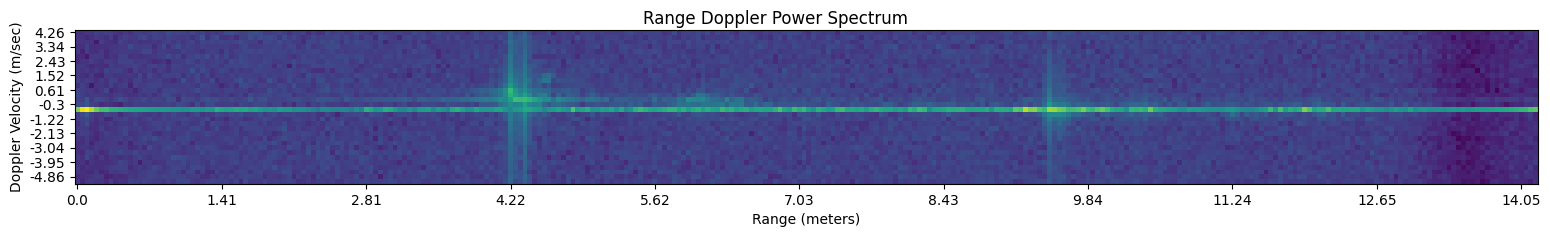

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(25, 2))
ax.imshow(range_doppler_psd)
fig.suptitle("Range Doppler Power Spectrum")
ax.set_xlabel("Range (meters)")
ax.set_ylabel("Doppler Velocity (m/sec)");

# apply Range and Doppler labels
ax.set_xticks(range_ticks, range_tick_labels);

ax.set_yticks(doppler_ticks, doppler_tick_labels);

## Make a video from the data

In [27]:
print(data_dict['radar'].shape)

(50, 32, 8, 304)


Acquire Processed Range Doppler

In [36]:
import cv2


frames = []

for i in range(len(data_dict['radar'])):

    # get raw ADC data
    adc_data = data_dict['radar'][i, ...]

    # perform Fast Time Range FFT
    range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

    # perform Slow Time Doppler FFT
    range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

    # compute Range Doppler Power Spectral Density in dB
    range_doppler_psd = 20*np.log10( np.abs(range_doppler)**2 )

    # Sum PSD across all virtual antennas and normalize
    range_doppler_psd = range_doppler_psd.sum(axis=1).T / range_doppler_psd.shape[1]

    # convert to normalized uint8 to save with opencv video writer
    frame = cv2.normalize(range_doppler_psd, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

    # append frame to list
    frames.append(frame)



Make Video

In [40]:
h, w = range_doppler_psd.shape

out = cv2.VideoWriter("../videos/range_doppler.avi",
                      cv2.VideoWriter_fourcc(*'DIVX'), # *'mp4v' *'MJPG' *'h264' *'x264' *'DIVX'
                      5,
                      (w, h))

for frame in frames:
    out.write(frame[:,:,None].repeat(3, axis=-1))

out.release()
del out

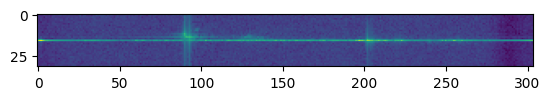

In [39]:
plt.imshow(frames[28])

## Now compute Range-Azimuth

In [391]:
def aoa_capon(x, a):
    """ Computes Capon Spectrum
        Inputs:
            x - output of 1D range FFT (v_rtx, num_chirps)
            a - steering vector (num_angles, v_rtx)
        Outputs:
            capon_spectrum - Computed Capon Spectrum (num_angles)
    """
    Rxx = x @ np.conj(x).T
    Rxx_inv = np.linalg.inv(Rxx)
    capon_spec = np.reciprocal(np.einsum('ij,ij->i', a.conj(), (Rxx_inv @ a.T).T))
    return capon_spec

In [392]:
def compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90):
    """ Computes array of Steering Vectors for a desired angluar range
        and resolution. **This is a special function that only computes the
        steering vectors along a 1D linear axis.**
        Inputs:
            angle_res - angle resolution in degrees
            angle_rng - single sided angle range
            num_ant - number of virtual antennas
        Output:
            steering_vectors
    """
    # get number of steering vectors based on desired angle range and resolution
    num_vec = (2 * angle_rng / angle_res + 1)
    num_vec = int(round(num_vec))

    # convert to radians
    angle_rng = angle_rng*np.pi/180
    angle_res = angle_res*np.pi/180

    # compute steering vectors
    steering_vectors = np.zeros((num_vec, num_ant), dtype=np.complex64)
    for k in range(num_vec):
        for m in range(num_ant):
            steering_vectors[k, m] = np.exp(-1j*np.pi*m
                                            *np.sin(-angle_rng + k*angle_res))
            
    return steering_vectors


In [393]:
steering_vector = compute_steering_vector(num_ant=8, angle_res=1.0, angle_rng=90)
steering_vector.shape

(181, 8)

In [394]:
range_doppler.shape

(304, 8, 32)

Before we compute the Angle Spectrum, we need to remove the velocity induced phase shift ;)

In [395]:
n_range_bins = range_doppler.shape[0]
n_angles = steering_vector.shape[0]

range_azimuth = np.zeros((n_range_bins, n_angles), dtype=np.complex64)

for i in range(range_doppler.shape[0]):
    range_azimuth[i,:] = aoa_capon(range_doppler[i, ...], steering_vector)

range_azimuth = np.flipud(np.fliplr(range_azimuth))

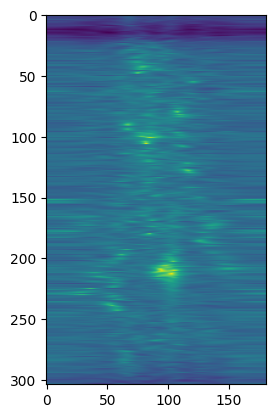

In [396]:
plt.imshow(20*np.log10(np.abs(range_azimuth)));

Now add the units

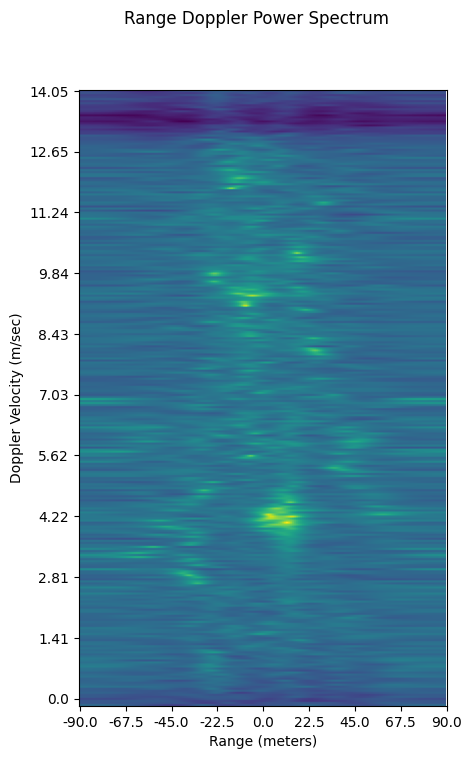

In [415]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax.imshow(20*np.log10(np.abs(range_azimuth)));
fig.suptitle("Range Azimuth Power Spectrum");
ax.set_xlabel("Azimuth Angle (degrees)");
ax.set_ylabel("Range (meters)");

# apply Range and Doppler labels
ax.set_yticks(range_ticks, range_tick_labels[::-1]);

ax.set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));